### 10.1 Cơ chế tập trung
- Trong phần trước, chúng ta sử dụng mạng hồi tiếp để mã hóa thông tin của chuỗi nguồn đầu vào thành trạng thái ẩn và truyền nó tới bộ giải mã để sinh chuỗi đích. 
- Một token trong chuỗi đích có thể chỉ liên quan mật thiết tới một vài token chứ không nhất thiết là toàn bộ token trong chuỗi nguồn. 
    + Ví dụ, khi dịch "Hello world." thành "Bonjour le monde.", từ "Bonjour" ánh xạ tới từ "Hello" và từ "monde" ánh xạ tới từ "world".
- Trong mô hình seq2seq, bộ giải mã có thể __ngầm chọn__ thông tin tương ứng từ trạng thái ẩn được truyền đến từ bộ mã hóa. __Tuy nhiên, cơ chế tập trung thực hiện phép chọn này một cách tường minh.__

- Cơ chế tập trung có thể được coi là phép gộp tổng quát. Nó gộp đầu vào dựa trên các trọng số khác nhau. Thành phần cốt lõi của cơ chế tập trung là tầng tập trung.
    1.  __Đầu vào của tầng tập trung được gọi là câu truy vấn (query)__. 
    2. Với mỗi câu truy vấn, __tầng tập trung trả về đầu ra dựa trên bộ nhớ là tập các cặp khóa - giá trị__ được mã hóa trong tầng tập trung này.
- Cụ thể, giả sử bộ nhớ chứa n cặp vector khóa - giá trị (k1, v1),..., (kn, vn) với 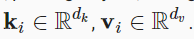. Với mỗi vector truy vấn 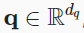, tầng tập trung trả về đầu ra  có cùng kích thước với vector giá trị.

    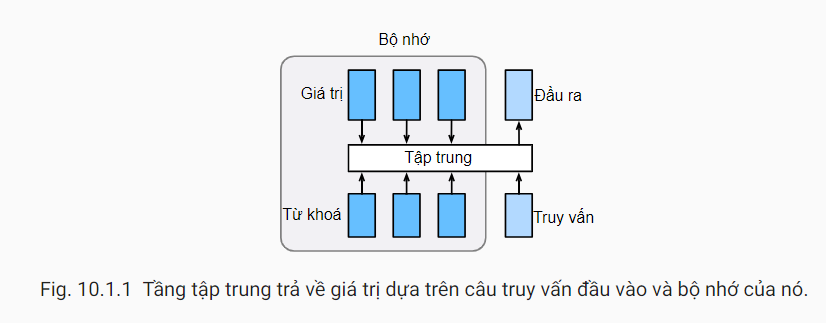

Chi tiết về cơ chế tập trung được minh họa trong hình trên. Để tính toán đầu ra của tầng tập trung, ta sử dụng hàm tính điểm alpha để đo độ tương đồng giữa câu truy vấn và các khóa. Sau đó, với mỗi khóa (k1, v1), ..., (kn, vn) ta tính điểm a1,..., an như sau:

    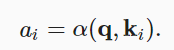

- Tiếp theo, ta sử dụng hàm softmax để thu được các trọng số tập trung (attention weight), cụ thể

    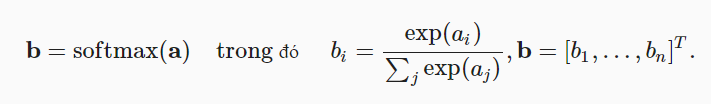

- Cuối cùng, đầu ra của tầng là tổng trọng số của các giá trị:


    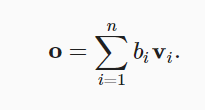

    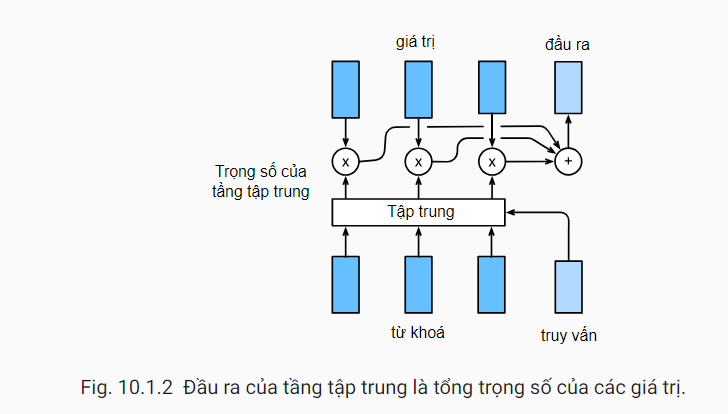

- Cách lựa chọn hàm tính điểm khác nhau sẽ tạo ra các tầng tập trung khác nhau. Ở dưới đây, chúng tôi sẽ trình bày hai tầng tập trung thường hay sử dụng. Đầu tiên, ta giới thiệu hai toán tử cần thiết để lập trình hai tầng này:
    1. Toán tử softmax có mặt nạ __masked_softmax__ 
    2. Toán tử tích vô hướng chuyên biệt theo batch là __batched_dot__

In [17]:
import math
from d2l import torch as d2l
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

In [18]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        # Vế trái (1, maxlen) so sánh với vế phải (len(valid_len), 1)
        # broad_cast thành (valid_len, maxlen) với (len(valid_len, max_len)
        # Tức là duplicate theo hàng và duplicate theo cột
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [19]:
masked_softmax(torch.rand(size=(2, 2, 4)), torch.tensor([2, 3]))

tensor([[[0.5584, 0.4416, 0.0000, 0.0000],
         [0.6248, 0.3752, 0.0000, 0.0000]],

        [[0.4393, 0.2827, 0.2781, 0.0000],
         [0.2716, 0.2329, 0.4955, 0.0000]]])

- Ngoài ra, toán tử thứ hai __batched_dot__ nhận hai đầu vào là X, Y có kích thước lần lượt là (b, n, m) và (b, m, k) thì trả về đầu ra có kích thước là (b, n, k). Cụ thể, toán tử này tính tích vô hướng với i = 1,..,b như sau:

    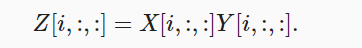

In [20]:
def batched_dot(X, Y):
    # X: (b, n, m), Y: (b, m, k)
    assert X.shape[0] == Y.shape[0]
    assert X.shape[-1] == Y.shape[1]

    data = [torch.mm(X[i], Y[i]) for i in range(X.shape[0])]
    return torch.stack(data)

In [21]:
batched_dot(torch.ones((2, 1, 3)), torch.ones((2, 3, 2)))
# shape: (2, 1, 2)

tensor([[[3., 3.]],

        [[3., 3.]]])

In [22]:
torch.bmm(torch.ones((2, 1, 3)), torch.ones((2, 3, 2)))

tensor([[[3., 3.]],

        [[3., 3.]]])

### Queries, Keys, and Values
- Cho đến giờ, tất cả các mạng mà ta xem xét đều phụ thuộc vào việc đầu vào có size cố định, Ví dụ, ảnh của ImageNet có kích thước 224 x 224 pixel và các mạng CNNs đều được định nghĩa để làm việc với kích thước này. Ngay cả trọng NLP, đầu vào của mạng RNNs cũng được định nghĩa rõ ràng và có kích thước cố định. 
- Việc tiếp cận này dẫn đến một vấn đề lớn khi đầu vào có nhiều kích thước và có nhiều loại thông tin. Như vậy, với chuỗi dài thì các mạng này trở nên khó khăn để theo dõi mọi thứ đã đực tạo hay được xem bởi mạng. 

- So sánh với cơ sở dữ liệu, ở dạng đơn giản nhất, nó là tập hợp các khóa k và giá trị v. Ví dụ, cơ sở dữ liệu D của ta có thể bao gồm các bộ {(“Zhang”, “Aston”), (“Lipton”, “Zachary”), (“Li”, “Mu”), (“Smola”, “Alex”), (“Hu”, “Rachel”), (“Werness”, “Brent”)} với họ là khóa và tên là giá trị. 
- Ví dụ với truy vấn chính xác (q) cho "Li" sẽ trả về giá trị "Mu". Nếu ("li", "mu") không có trọng cơ sở dữ liệu thì sẽ không có câu trả lời hợp lệ và ta có thể lấy câu trả lời gần đúng như (“Lipton”, “Zachary”) để thay thế.
- Ta rút ra được một vài điều sau:
    1. Ta có thể thiết kế ra các truy vấn q hoạt động trên các cặp khóa (k, v) bất kể kích thước cơ sở dữ liệu.
    2. Cùng một truy vấn có thể nhận được nhiều câu trả lời khác nhau tùy theo nội dung của cơ sở dữ liệu.
    3. Không cần phải nén hoặc đơn giản hóa cơ sở dữ liệu để thực hiện các hoạt động hiệu quả.
    4. Code để vận hành trên không gian trạng thái lớn có thể khá đơn giản (ví dụ: Khớp chính xác, khớp gần đúng, ...)

    

#### Dot product attention

In [37]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # query:    (batch_size, num_queries, d)
    # key:      (batch_size, num_pairs, d)
    # value:    (batch_size, num_pairs, dim_v)
    # valid_len: (batch_size, ) or (batch_size, num_queries)

    def forward(self, query, key, value, valid_len = None):
        d = torch.tensor(query.shape[-1])
        # Shape of score: (batch_size, num_queries, num_pairs)
        score = torch.bmm(query, key.transpose(1, 2)) / torch.sqrt(d)
        self.attention_weight = self.dropout(masked_softmax(score, valid_len))
        return torch.bmm(self.attention_weight, value)

- Ta kiểm tra lớp __DotProductAttention__ với một ví dụ nhỏ sau: Đầu tiên ta tạo 2 batch, mỗi batch có một câu truy vấn và 10 cặp khóa - giá trị. Thông qua đối số __valid_len__ ta chỉ định rằng ta sẽ kiểm tra 2 cặp khóa - giá trị đầu tiên cho batch đầu tiên và 6 cặp cho batch thứ hai. Do đó, mặc dù cả hai batch đều có cùng câu truy vấn và các cặp khóa - giá trị, chúng ta sẽ thu được các đầu ra khác nhau.

In [58]:
atten = DotProductAttention(dropout=0.5)
batch_size, num_pairs, d, dim_v = 2, 10, 2, 4
keys = torch.ones((batch_size, num_pairs, d))
values = torch.arange(40, dtype = torch.float32).reshape(1, num_pairs, dim_v)
values = torch.stack([values, values], dim = 0).squeeze()
atten(torch.ones((batch_size, 1, d)), keys, values, torch.tensor([2, 6]))

tensor([[[ 4.0000,  5.0000,  6.0000,  7.0000]],

        [[20.0000, 21.6667, 23.3333, 25.0000]]])

- Như đã thấy ở trên, tập trung tích vô hướng chỉ đơn thuần nhân câu truy vấn với khóa lại với nhau, hy vọng rằng từ đó thu được những điểm tương đồng giữa chúng. Tuy nhiên, câu truy vấn và khóa có thể không cùng kích thước với nhau. 
- Để giải quyết vấn đề này, tă cần nhờ đến cơ chế tập trung perceptron đa tầng.

#### 2. Tập trung Perceptron Đa tầng

In [ ]:
class MLPAttention(nn.Module):
    def __init__(self, units, dropout):
        super().__init__()
        self.W_k = nn.LazyLinear(units, bias = False)
        self.W_q = nn.LazyLinear(units, bias = False)
        self.v = nn.LazyLinear(1, bias = False)
        self.dropout = nn.Dropout(dropout)

    # query:    (batch_size, num_queries, d_q)
    # key:      (batch_size, num_pairs, d_k)
    # value:    (batch_size, num_pairs, dim_v)
    # valid_len:(batch_size, ) or (batch_size, num_queries)
    def forward(self, query, key, value, valid_len):
        query, key = self.W_q(query), self.W_k(key)
        # (batch_size, num_queries, 1, units)
        query = query.unsqueeze(2)
        
        # (batch_size, 1, num_pairs, units)
        key = key.unsqueeze(1)

        # Plus with broadcast
        # score shape: (batch_size, num_queries, num_pairs)
        score = self.v(torch.tanh(query + key)).squeeze(-1)

        self.attention_weight = self.dropout(d2l.masked_softmax(score, valid_len))

        # Result shape: (batch_size, num_queries, dim_v)
        return torch.bmm(self.attention_weight, value)

In [133]:
atten = MLPAttention(units = 8, dropout=0.1)
atten(torch.ones((2, 1, 2)), keys, values, torch.tensor([2, 6]))

tensor([[[ 0.0000,  0.5556,  1.1111,  1.6667]],

        [[11.1111, 12.2222, 13.3333, 14.4444]]], grad_fn=<BmmBackward0>)